In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [5]:
# Define data transformations with data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(0.2),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)], p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
data_dir = 'D:/exam/TrashNet/'

# Load dataset with transformations
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply the validation transformations to val and test datasets
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['val']

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Check the split sizes
print(f'Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}')

# Get class names from the original dataset
class_names = dataset.classes
num_classes = len(class_names)
print(f'Class names: {class_names}, Number of classes: {num_classes}')

Train size: 2021, Validation size: 252, Test size: 254
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], Number of classes: 6


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier part of the model with regularization
model.classifier[6] = nn.Sequential(
    nn.Linear(model.classifier[6].in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),  # Increase dropout rate
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)
model = model.to(device)

In [8]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.00001, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, min_lr=0.000001)

In [9]:
# Training the model
num_epochs = 20
early_stop_patience = 3
best_model_wts = model.state_dict()
best_acc = 0.0
early_stop_counter = 0

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = train_loader
        else:
            model.eval()  # Set model to evaluate mode
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Deep copy the model
        if phase == 'val':
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc.cpu().numpy())  # Move to CPU and convert to numpy
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                early_stop_counter = 0  # Reset early stop counter
            else:
                early_stop_counter += 1
        else:
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc.cpu().numpy())  # Move to CPU and convert to numpy

    # Step the scheduler
    scheduler.step(epoch_loss)

    if early_stop_counter >= early_stop_patience:
        print("Early stopping")
        break

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/20
----------
train Loss: 1.7146 Acc: 0.3112
val Loss: 1.5494 Acc: 0.5873
Epoch 2/20
----------
train Loss: 1.3671 Acc: 0.5087
val Loss: 0.9947 Acc: 0.6667
Epoch 3/20
----------
train Loss: 0.9619 Acc: 0.6447
val Loss: 0.7305 Acc: 0.7341
Epoch 4/20
----------
train Loss: 0.7475 Acc: 0.7190
val Loss: 0.6041 Acc: 0.7738
Epoch 5/20
----------
train Loss: 0.6009 Acc: 0.7843
val Loss: 0.5813 Acc: 0.7937
Epoch 6/20
----------
train Loss: 0.4898 Acc: 0.8268
val Loss: 0.5332 Acc: 0.8214
Epoch 7/20
----------
train Loss: 0.3955 Acc: 0.8634
val Loss: 0.4925 Acc: 0.8254
Epoch 8/20
----------
train Loss: 0.3003 Acc: 0.8981
val Loss: 0.4796 Acc: 0.8373
Epoch 9/20
----------
train Loss: 0.2393 Acc: 0.9283
val Loss: 0.4729 Acc: 0.8294
Epoch 10/20
----------
train Loss: 0.1882 Acc: 0.9451
val Loss: 0.4706 Acc: 0.8492
Epoch 11/20
----------
train Loss: 0.1392 Acc: 0.9649
val Loss: 0.4939 Acc: 0.8413
Epoch 12/20
----------
train Loss: 0.0997 Acc: 0.9767
val Loss: 0.5197 Acc: 0.8492
Epoch 13/20
-

<All keys matched successfully>

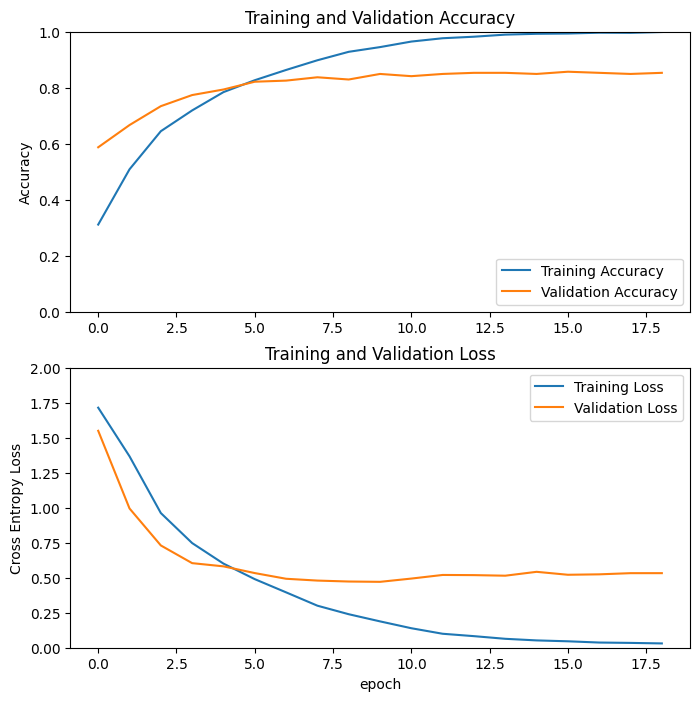

In [10]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, 2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [11]:
# Evaluate on the training set
model.eval()
train_loss = 0.0
train_corrects = 0

y_true_train = []
y_pred_train = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        train_loss += loss.item() * inputs.size(0)
        train_corrects += torch.sum(preds == labels.data)
        
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

train_loss = train_loss / len(train_loader.dataset)
train_acc = train_corrects.double() / len(train_loader.dataset)

print('Training Loss: {:.4f} Training Acc: {:.4f}'.format(train_loss, train_acc))

# Calculate precision, recall, f1-score for the training set
print('Training Precision:', precision_score(y_true_train, y_pred_train, average='weighted'))
print('Training Recall:', recall_score(y_true_train, y_pred_train, average='weighted'))
print('Training F1 Score:', f1_score(y_true_train, y_pred_train, average='weighted'))

# Evaluate on the test set
model.eval()
test_loss = 0.0
test_corrects = 0

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)

print('Test Loss: {:.4f} Test Acc: {:.4f}'.format(test_loss, test_acc))

# Calculate precision, recall, f1-score
print('Test Precision:', precision_score(y_true, y_pred, average='weighted'))
print('Test Recall:', recall_score(y_true, y_pred, average='weighted'))
print('Test F1 Score:', f1_score(y_true, y_pred, average='weighted'))

Training Loss: 0.0050 Training Acc: 0.9995
Training Precision: 0.9995067039982622
Training Recall: 0.9995051954477981
Training F1 Score: 0.9995044116481634
Test Loss: 0.4689 Test Acc: 0.8465
Test Precision: 0.8476515623516986
Test Recall: 0.8464566929133859
Test F1 Score: 0.8418873224475001


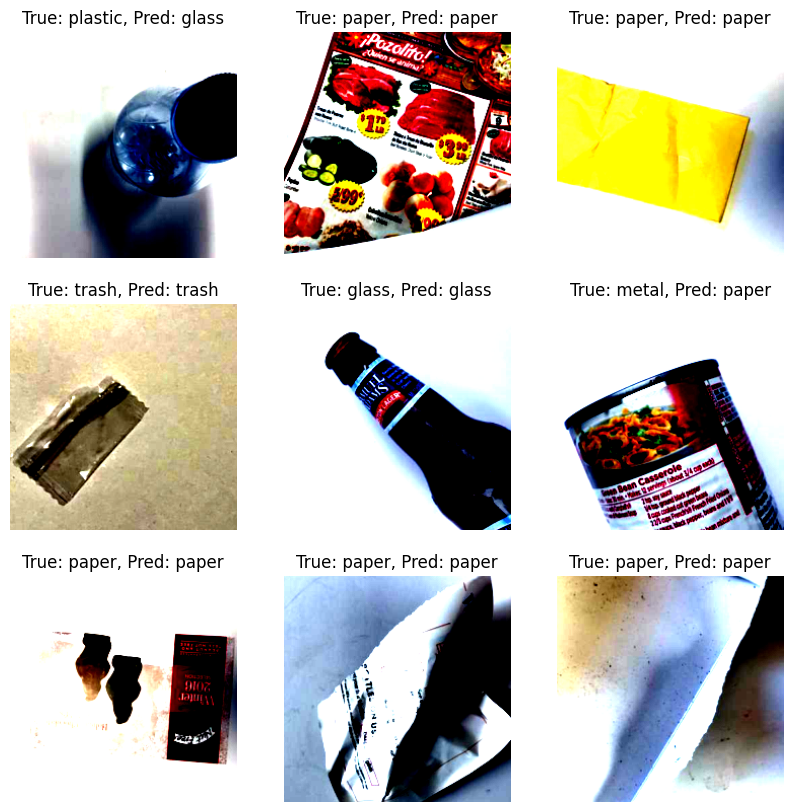

In [13]:
# Visualize predictions
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Convert images and predictions to numpy for visualization
images_np = images.cpu().numpy().transpose((0, 2, 3, 1))
images_np = np.clip(images_np, 0, 1)
preds_np = preds.cpu().numpy()
labels_np = labels.cpu().numpy()

# Plot images with predicted and true labels
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_np[i])
    plt.title(f"True: {class_names[labels_np[i]]}, Pred: {class_names[preds_np[i]]}")
    plt.axis("off")
plt.show()